In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR, 
                          plot_tree, 
                          export_text)
from sklearn.ensemble import (RandomForestClassifier as RFC,GradientBoostingRegressor as GBR, RandomForestRegressor as RF)
from sklearn.metrics import (accuracy_score, 
                             log_loss)
from ISLP.bart import BART

In [63]:
data = load_data("Carseats")
high = np.where(data.Sales > 8, "Yes", "No")
design = MS(data.columns.drop("Sales"), intercept=False)
x = design.fit_transform(data)
feature_names = x.columns
x_dat = np.asarray(x)


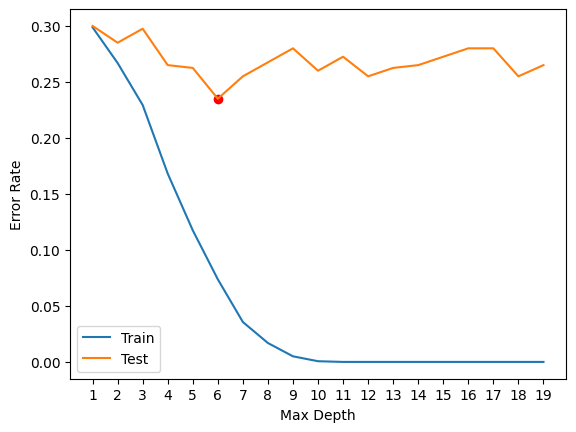

In [64]:
max_depth = np.arange(1,20)
cv = skm.ShuffleSplit(5, test_size=0.2, random_state=0)
train_err = np.zeros_like(max_depth, dtype=float)
test_err = np.zeros_like(max_depth, dtype=float)

for train_idx, test_idx in cv.split(x_dat) : 
    x_train, x_test = x_dat[train_idx], x_dat[test_idx]
    y_train, y_test = high[train_idx], high[test_idx]
    for i, d in enumerate(max_depth) : 
        dtc = DTC(max_depth=d)
        dtc.fit(x_train, y_train)
        train_err[i] += 1 - accuracy_score(y_train, dtc.predict(x_train))
        test_err[i] += 1 - accuracy_score(y_test, dtc.predict(x_test))
train_err /= cv.get_n_splits()
test_err /= cv.get_n_splits()

fig, ax = plt.subplots()
ax.plot(max_depth, train_err, label="Train")
ax.plot(max_depth, test_err, label="Test")
ax.scatter(np.argmin(test_err)+1, np.min(test_err), color="red")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Error Rate")
ax.set_xticks(max_depth)
ax.legend()
plt.show()

# max_depth = 6 - performs well

In [ ]:
clf = DTC(max_depth=6, criterion="entropy", random_state=0)
clf.fit(x_dat, high)


0.91

In [77]:
resid_dev = np.sum(log_loss(high, clf.predict_proba(x_dat)))
print(f"Residual deviance: {resid_dev:.3f}")
print(f"Accuracy Score : {accuracy_score(high, clf.predict(x_dat)):.3f}")

Residual deviance: 0.181
Accuracy Score : 0.910


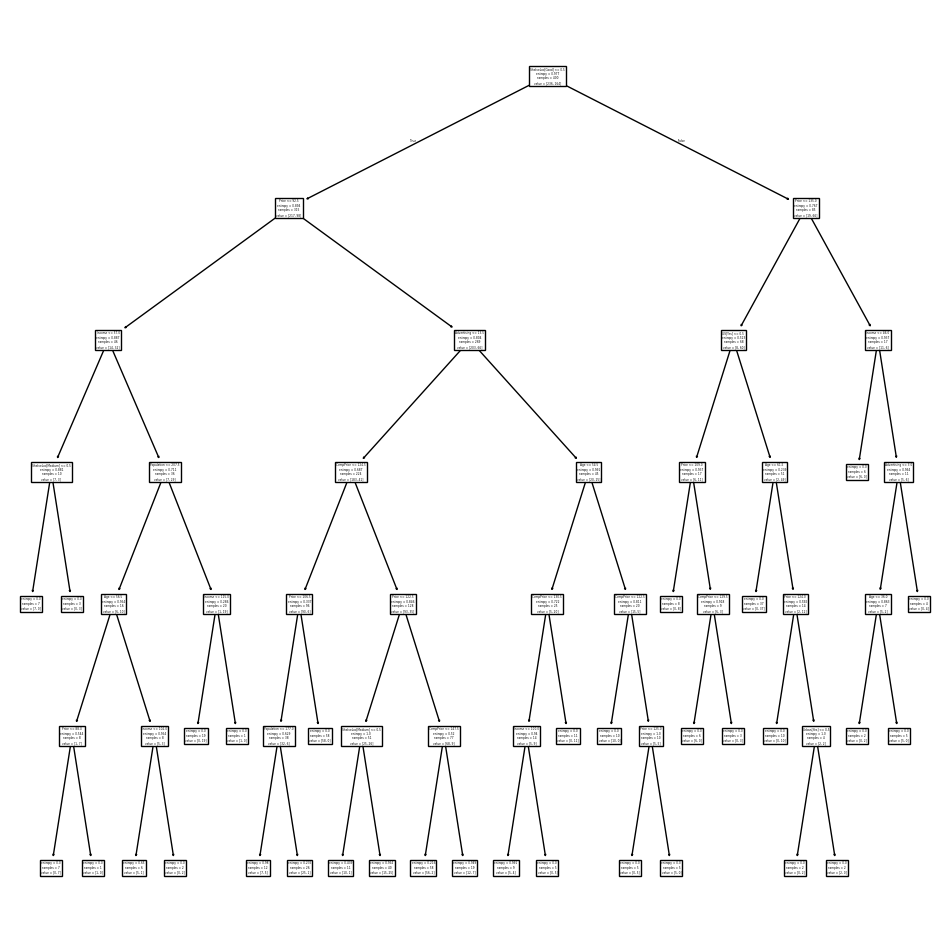

In [83]:
fig, ax = plt.subplots(figsize=(12,12))
plot_tree(clf, feature_names=feature_names, ax = ax)
plt.show()

In [86]:
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLoc[Medium] <= 0.50
|   |   |   |   |--- weights: [7.00, 0.00] class: No
|   |   |   |--- ShelveLoc[Medium] >  0.50
|   |   |   |   |--- weights: [0.00, 3.00] class: Yes
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- weights: [0.00, 7.00] class: Yes
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: No
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Income <= 102.00
|   |   |   |   |   |   |--- weights: [5.00, 1.00] class: No
|   |   |   |   |   |--- Income >  102.00
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: Yes
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- weights: [0.00, 19.00] class: Yes
|   |   |   |   |--- Income >  115.00
|   |  

In [89]:
cv = skm.ShuffleSplit(5, test_size=0.2, random_state=0)
results = skm.cross_validate(clf, x_dat, high, cv=cv, return_train_score=True)
print(f"Train Score: {results['train_score'].mean():.3f}")
print(f"Test Score: {results['test_score'].mean():.3f}")

Train Score: 0.920
Test Score: 0.753


In [117]:
# Pruning might lead to improved performance
clf = DTC(max_depth=6, criterion="entropy", random_state=0)

cv = skm.ShuffleSplit(1, test_size=0.4, random_state=0)
for train_idx, test_idx in cv.split(x_dat) : 
    x_train, x_test = x_dat[train_idx], x_dat[test_idx]
    y_train, y_test = high[train_idx], high[test_idx]
    clf.fit(x_train, y_train)
    print(f"Train Score: {accuracy_score(y_train, clf.predict(x_train)):.3f}")
    print(f"Test Score: {accuracy_score(y_test, clf.predict(x_test)):.3f}")
    

Train Score: 0.925
Test Score: 0.738


In [116]:
confusion_table(y_test, clf.predict(x_test))

Truth,No,Yes
Predicted,,
No,72,18
Yes,24,46


Analysis of confusion table : 
- Accuracy = $\frac{72 + 46}{160} \approx 0.7375 (73.75\%)$
- Precision = $\frac{46}{46+24} \approx 0.6571 (65.71\%)$
- Recall = $\frac{46}{46+18} \approx 0.71875 (71.875\%)$
- Specificity = $\frac{72}{72 + 24} \approx 0.75 (75\%)$

Precision : Of all Predicted positives, how many were true positives. -> False Positives Rate
Recall : Of all Actual positives, how many were true positives. -> False Negative Rate
Specificity : Of all Actual negatives, how many were true negatives -> False Positives

In [122]:
ccp_path = clf.cost_complexity_pruning_path(x_train, y_train) # Yield
kfold = skm.ShuffleSplit(5, test_size=0.2, random_state=0)
alpha = ccp_path["ccp_alphas"]
grid = skm.GridSearchCV(clf, {"ccp_alpha": alpha}, cv=kfold, refit=True, scoring="accuracy")
grid.fit(x_train, y_train)
grid.best_score_

0.7208333333333333

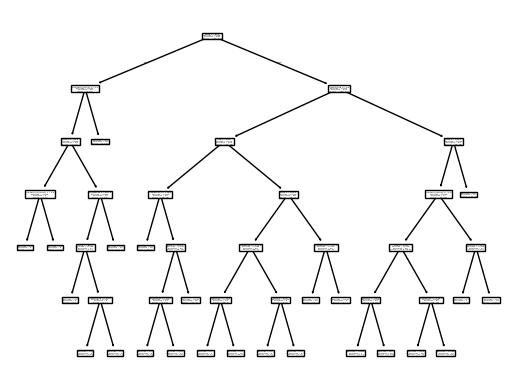

In [124]:
fig, ax = plt.subplots()
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax)
plt.show()

# Still a very bushy tree

In [127]:
best_.tree_.n_leaves
# The tree with 24 leaves, results a crossValidated accuracy of 0.72

24

In [132]:
confusion_table(y_test, best_.predict(x_test))

Truth,No,Yes
Predicted,,
No,72,18
Yes,25,45


Analysis :
1. Accuracy : $\frac{72 + 45}{160} \approx 0.731 (73.1\%)$
2. Precision : $\frac{45}{45 + 25} \approx 0.64285 (64.28\%)$
3. Recall : $\frac{45}{45 + 18} \approx 0.71428 (71.42\%)$
4. Specificity : $\frac{72}{72+25} \approx 0.7422 (74.22\%)$

Inferences : 
- Around 64.28% of predicted positives were actual positives
- Around 71.42% of actual positives were true positives
- Around 74.22% of actual negatives were true negatives

There could be a lot of false positives & negatives as evident by the numbers

In [133]:
# Fitting regression trees
data_boston = load_data("Boston")
design = MS(data_boston.columns.drop("medv"), intercept=False)
x = design.fit_transform(data_boston)
feature_names = x.columns
x_dat = np.asarray(x)
y = data_boston.medv

In [155]:
cv = skm.ShuffleSplit(5, test_size=0.3, random_state=0)
reg = DTR(max_depth=4, random_state=0)

train_score = 0
test_score = 0

for train_idx, test_idx in cv.split(x_dat) : 
    x_train, x_test = x_dat[train_idx], x_dat[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    reg.fit(x_train, y_train)
    train_mse = np.mean((y_train - reg.predict(x_train))**2)
    test_mse = np.mean((y_test - reg.predict(x_test))**2)
    train_score += train_mse
    test_score += test_mse
train_score /= cv.get_n_splits()
test_score /= cv.get_n_splits()

print(f"Train Error : {train_score:.3f}")
print(f"Test Error : {test_score:.3f}")

Train Error : 8.486
Test Error : 29.626


In [160]:
# Alternative implmentation
eval = skm.cross_validate(reg, x_dat, y, cv=cv, return_train_score=True, scoring="neg_mean_squared_error")

print(f"Train Error : {-eval['train_score'].mean():.3f}")
print(f"Test Error : {-eval['test_score'].mean():.3f}")

Train Error : 8.486
Test Error : 29.626


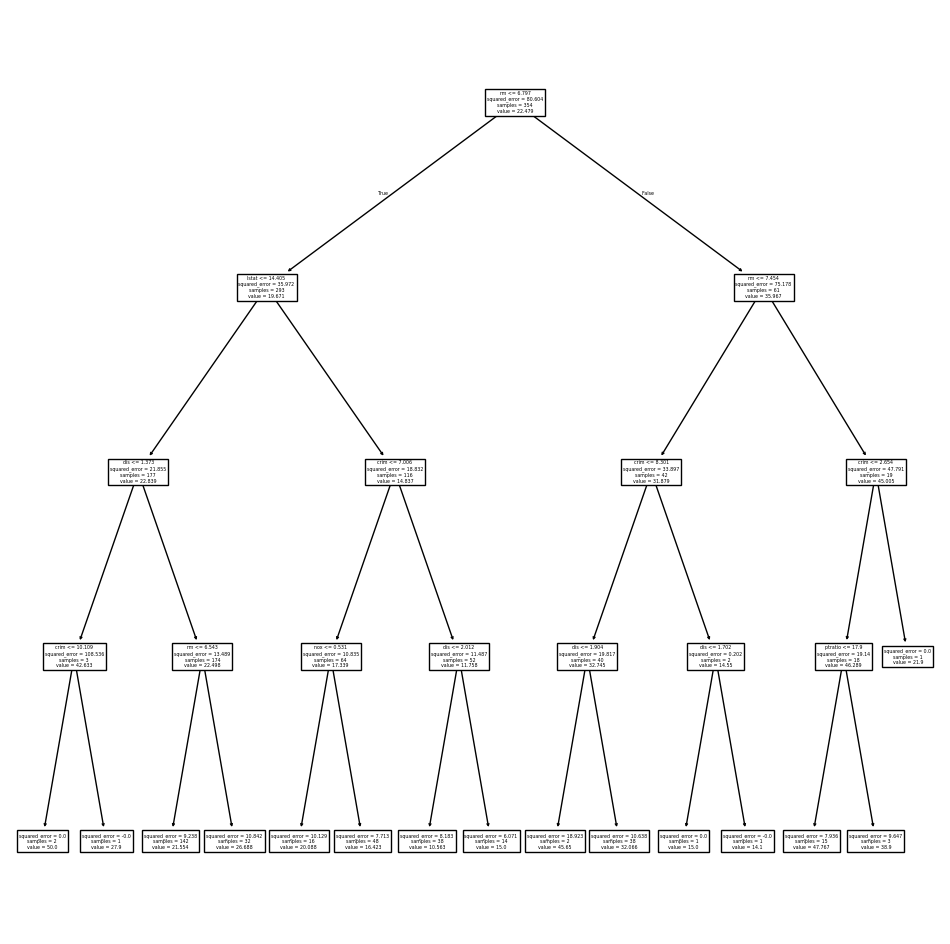

In [163]:
# Plotting the regression tree
fig, ax = plt.subplots(figsize=(12,12))
plot_tree(reg, feature_names=feature_names, ax=ax)
plt.show()

# Quite bushy tree

In [165]:
print(export_text(reg, feature_names=feature_names, show_weights=True))

|--- rm <= 6.80
|   |--- lstat <= 14.40
|   |   |--- dis <= 1.37
|   |   |   |--- crim <= 10.11
|   |   |   |   |--- value: [50.00]
|   |   |   |--- crim >  10.11
|   |   |   |   |--- value: [27.90]
|   |   |--- dis >  1.37
|   |   |   |--- rm <= 6.54
|   |   |   |   |--- value: [21.55]
|   |   |   |--- rm >  6.54
|   |   |   |   |--- value: [26.69]
|   |--- lstat >  14.40
|   |   |--- crim <= 7.01
|   |   |   |--- nox <= 0.53
|   |   |   |   |--- value: [20.09]
|   |   |   |--- nox >  0.53
|   |   |   |   |--- value: [16.42]
|   |   |--- crim >  7.01
|   |   |   |--- dis <= 2.01
|   |   |   |   |--- value: [10.56]
|   |   |   |--- dis >  2.01
|   |   |   |   |--- value: [15.00]
|--- rm >  6.80
|   |--- rm <= 7.45
|   |   |--- crim <= 8.30
|   |   |   |--- dis <= 1.90
|   |   |   |   |--- value: [45.65]
|   |   |   |--- dis >  1.90
|   |   |   |   |--- value: [32.07]
|   |   |--- crim >  8.30
|   |   |   |--- dis <= 1.70
|   |   |   |   |--- value: [15.00]
|   |   |   |--- dis >  1.70


In [177]:
# Prunning the tree
ccp_path = reg.cost_complexity_pruning_path(x_train, y_train)
alpha = ccp_path["ccp_alphas"]
grid = skm.GridSearchCV(reg, {"ccp_alpha": alpha}, cv=cv, refit=True, scoring="neg_mean_squared_error")
grid.fit(x_train, y_train)
best_ = grid.best_estimator_
print(f"The best alpha is {best_.ccp_alpha:.3f}")
print(f"The best RSS is {-grid.best_score_:.3f}")

The best alpha is 1.592
The best RSS is 28.839


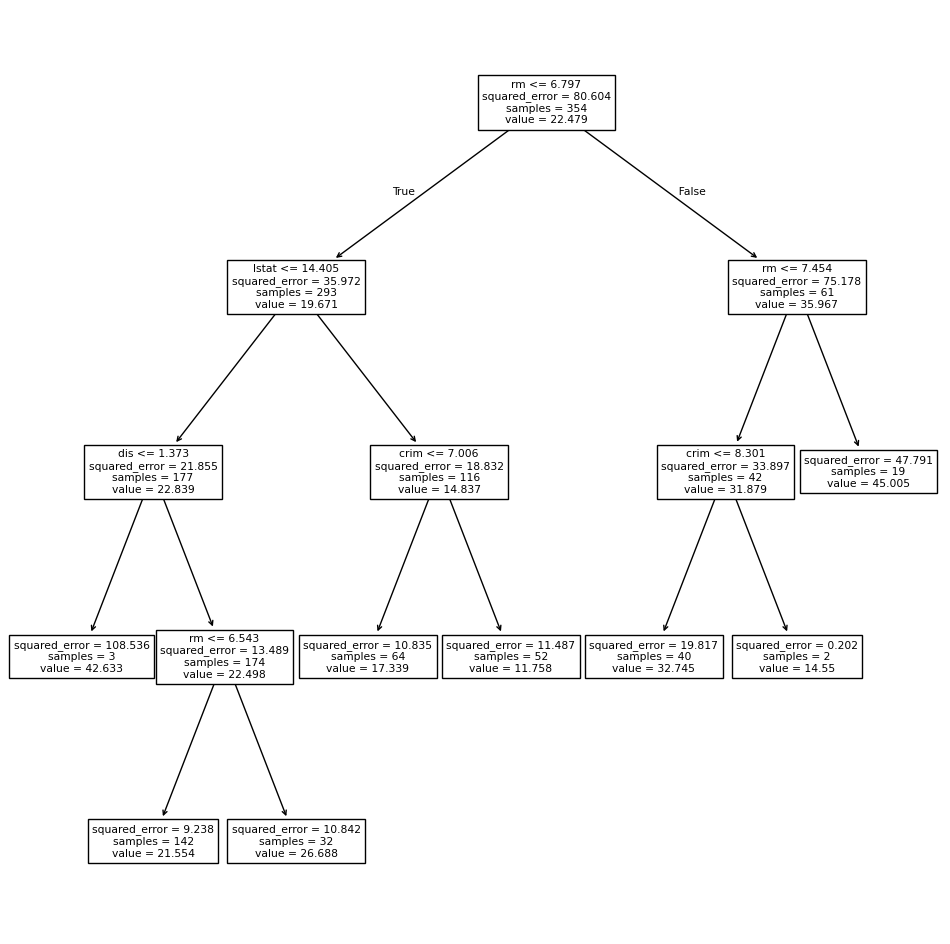

In [202]:
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(best_, feature_names=feature_names, ax=ax)
plt.show()

In [207]:
# Random Forests
data_bos = load_data("Boston")
data_bos.head()
design = MS(data_bos.columns.drop("medv"), intercept=False)
x = design.fit_transform(data_bos)
feature_names = x.columns
x_dat = np.asarray(x)
y = data_bos.medv

cv = skm.ShuffleSplit(1, test_size=0.3, random_state=0)
train_idx, test_idx = next(cv.split(x_dat))
x_train, x_test = x_dat[train_idx], x_dat[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [214]:
# Remember that boosting is a special case of random forests, where m = p
# Random forest it is usally m = sqrt(p)

bag_bos = RF(max_features=x_train.shape[1], random_state=0)
bag_bos.fit(x_train, y_train)


RandomForestRegressor(max_features=12, random_state=0)

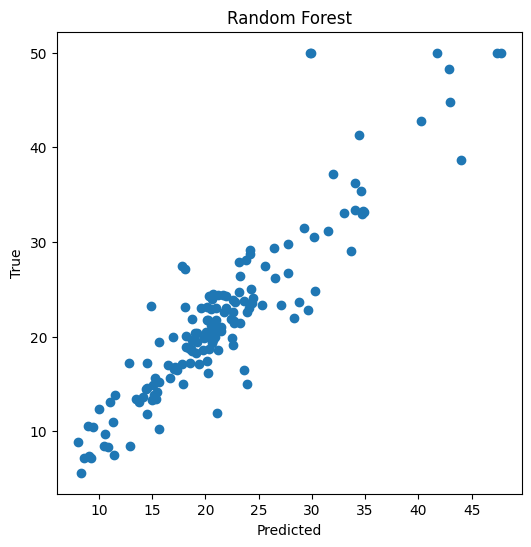

14.684333796052627

In [222]:
fig, ax = plt.subplots(figsize=(6,6))
y_pred = bag_bos.predict(x_test)
ax.scatter(y_pred, y_test)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Random Forest")
plt.show()
np.mean((y_pred - y_test)**2)  

In [228]:
# Increasing the number of trees grown. 
bag_bos_noi = RF(n_estimators=500, max_features=x_train.shape[1], random_state=0)
bag_bos_noi.fit(x_train, y_train)
y_pred = bag_bos_noi.predict(x_test)
test_err = np.mean((y_pred - y_test)**2)

print(f"Test Error : {test_err:.3f} with trees = 500")


Test Error : 14.565 with trees = 500


In [239]:
# Fitting random forest, max_fea = sqrt(p)
rf_boston = RF(max_features = 6, random_state=0, n_estimators=500)
rf_boston.fit(x_train, y_train)
y_pred = rf_boston.predict(x_test)
test_err = np.mean((y_pred - y_test)**2)
print(f"Test Error : {test_err:.3f}")

Test Error : 18.753


The Test MSE is somewhat worse than bagging, i mean quite worse. Here random forest is not performing well. 

We know that feature importance can be calculatd by just removing the feature and measuring the drop in the parameters / estimated accuracy - defined well. 

In [242]:
feature_imp = pd.DataFrame({"importance" : rf_boston.feature_importances_}, index=feature_names)
feature_imp.sort_values(by="importance", ascending=False)

,importance
lstat,0.367785
rm,0.335036
ptratio,0.056495
crim,0.052865
indus,0.052762
dis,0.042371
nox,0.034668
age,0.023721
tax,0.022616
rad,0.005593


Suprisingly we can get around 80% importance using couple of parameters, maybe the 80/20 rules holds here. 

Remember this a relative measure, RF basically grows out many trees and the overall prediction is averaged over. 

From below we will be using boosting, which basically grows trees on the residuals.

#### Boosting

In [278]:
boost_bos = GBR(n_estimators=100, learning_rate=0.2, max_depth=4, random_state=0)
boost_bos.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, random_state=0)

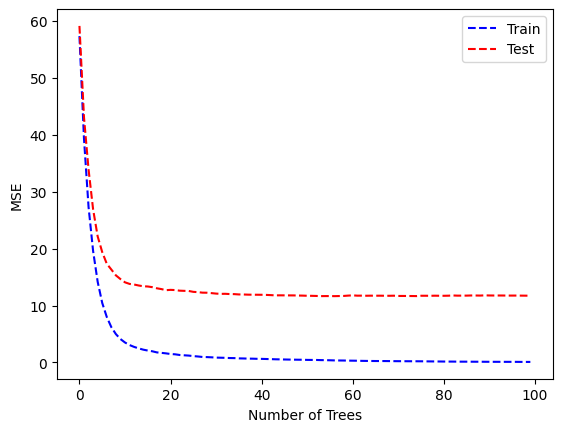

In [279]:
test_err = np.zeros_like(boost_bos.train_score_)
for test_idx, y_ in enumerate(boost_bos.staged_predict(x_test)) : 
    test_err[test_idx] = np.mean((y_ - y_test)**2)

plot_idx = np.arange(boost_bos.train_score_.shape[0])
fig, ax = plt.subplots()
ax.plot(plot_idx, boost_bos.train_score_, "b--", label="Train")
ax.plot(plot_idx, test_err, "r--" ,label="Test")
ax.set_xlabel("Number of Trees")
ax.set_ylabel("MSE")
ax.legend()
plt.show()

In [280]:
# Comparing
y_hat = boost_bos.predict(x_test)
np.mean((y_hat - y_test)**2)

# Similar results as Bagging

11.714514226159102

But if you adjust the $\lambda \approx 0.2$ then you can basically get a faster covergence ?

With $\lambda = 0.001$ we were converging in around 5000 trees and here we are converging around 20 and getting a better value of MSE

In [292]:
# Bayesian Additive regression trees 
bart_bos = BART(random_state=0, burnin=5, ndraw=15)
bart_bos.fit(x_train, y_train)
y_hat = bart_bos.predict(x_test.astype(np.float32))
np.mean((y_hat - y_test)**2)

# I don't understand this -> Need to understand more


22.145009458109225

In [294]:
var_inclusion = pd.Series(bart_bos.variable_inclusion_.mean(0), index=feature_names)
var_inclusion.sort_values(ascending=False)

# Gives us the variable importance

lstat      31.000000
rm         29.800000
zn         27.866667
crim       26.933333
nox        26.600000
indus      26.466667
dis        26.466667
ptratio    24.266667
tax        24.133333
rad        23.666667
age        22.733333
chas       22.466667
dtype: float64

#### Functions Used : 
- `np.where(condition, ifTrue, ifFalse)` -> For classifying
- `DecisionTreeClassifier()` : For a decision tree classifying
- `cost_complexity_path()` : To extract cost-complexity values and impurities values to be used for prunning
- `DecisionTreeRegressor()` : For making trees for regression
- `RandomForestRegressor()` : Bagging is simply a special case for random forest with `m = p`
  - Bagging and random forest cannot overfit but can underfit if the number of trees grown is not that good.
- `GradientBoostingRegressor()` : Applies the boosting techniques to the random forest. 
  - `stagedPredict()` : gives us the prediction in each stage. 

##### Notes : 
- We have converted from `DataFrame` to `np.ndarray()` because `DTC` support only numpy array
- HyperParameters : 
  - `max_depth` : how deep to grow the tree
  - `min_samples_split` : minimum number of observations in a node to be eligible for splitting
  - `criterion` : which criteria to use for splitting i.e. Gini or cross - entropy
- `accuracy_score(y, predicted)` : accuracy score for the predictions 

##### Tasks : 
- Code this from scratch ; Every algorithmns
- Clarity on what is difference between random forest and bagging
- Why random forest & bagging cannot overfit ? While Boosting can ? 
- What are BART and hwo they are constructed.